In [1]:
import secrets

# from mcfacts.mcfacts_random_state import reset_random
# 
# reset_random(223849053863469657747974663531730220530)

secrets.randbits(128)

255167430971232103865932043846209015976

In [2]:
from tqdm.auto import tqdm

from mcfacts.objects.agn_disk import AGNDisk
from mcfacts.objects.agn_object_array import AGNBinaryBlackHoleArray
from mcfacts.objects.filing_cabinet import FilingCabinet
from mcfacts.objects.galaxy import Galaxy
from mcfacts.inputs.settings_manager import SettingsManager
from mcfacts.objects.galaxy_populator import SingleBlackHolePopulator, SingleStarPopulator
from mcfacts.objects.simulation_actor import ReclassifyDiskObjects, ProgradeBlackHoleDynamics, \
    RetrogradeBlackholeDynamics, BinaryBlackHoleDynamics, BinaryBlackHoleFormation, BreakupBinaryBlackHoles
from mcfacts.objects.simulation_timeline import SimulationTimeline

from matplotlib import pyplot as plt

In [3]:
# Seed should be 128 bits long to ensure random has enough entropy (as per NumPy documentation)
#
# import secrets
# secret.randombits(128)

settings = SettingsManager({
    "verbose": False,
    "show_timeline_progress": False,
    "override_files": True
})

population_cabinet = FilingCabinet()

agn_disk = AGNDisk(settings)

n_galaxy = 10

pbar = tqdm(total=n_galaxy, position=0, leave=True)

for galaxy_id in range(n_galaxy):
    pbar.set_description(f"Running Galaxy {galaxy_id}") 
    pbar.update(1)
    
    galaxy_seed = 223849053863469657747974663531730220530 - galaxy_id
    
    # Create instance of galaxy
    galaxy = Galaxy(seed=galaxy_seed, runs_folder="./runs", galaxy_id=galaxy_id, settings=settings)
    
    # Create instance of populators
    single_bh_populator = SingleBlackHolePopulator()
    #single_star_populator = SingleStarPopulator("single_stars")
    galaxy.populate([single_bh_populator], agn_disk)
    
    # Create timeline to classify objects created during population
    pre_timeline = SimulationTimeline("Reclassification", timesteps=1, timestep_length=0)
    pre_timeline.add_simulation_actor(ReclassifyDiskObjects())
    galaxy.run(pre_timeline, agn_disk)
    
    # Create timeline to run main simulation
    dynamics_timeline = SimulationTimeline("Dynamics", timesteps=1000, timestep_length=galaxy.settings.timestep_duration_yr)
    dynamics_timeline.add_simulation_actor(ProgradeBlackHoleDynamics(settings=settings))
    #dynamics_timeline.add_simulation_actor(RetrogradeBlackholeDynamics(settings=settings))
    dynamics_timeline.add_simulation_actor(BinaryBlackHoleDynamics(settings=settings))
    dynamics_timeline.add_simulation_actor(BinaryBlackHoleFormation(settings=settings))
    galaxy.run(dynamics_timeline, agn_disk)
    
    # Create timeline to cleanup the final bits and bobs at the end of a
    cleanup_timeline = SimulationTimeline("Cleanup", timesteps=1, timestep_length=0)
    cleanup_timeline.add_simulation_actor(BreakupBinaryBlackHoles())
    galaxy.run(cleanup_timeline, agn_disk)
    
    if "blackholes_merged" in galaxy.filing_cabinet:
        population_cabinet.create_or_append_array("blackholes_merged", galaxy.filing_cabinet.get_array("blackholes_merged"))
       
pbar.close()

### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+08 MSun
Mdot = 2.596689e+00 MSun/yr
le = 1.0
Rs = 9.570121e-06 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e+01 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=3502 (R=9.06e+02 Rs)
Beginning star formation at index 3502
Mdisk = 422372550.27166283 Msun
Mdisk/Mbh = 4.223725502716628


  0%|          | 0/10 [00:00<?, ?it/s]

In [8]:
print(galaxy.timeline_history[0].get_simulation_actor(0).settings.settings_finals)

{'verbose': False, 'smbh_mass': 100000000.0, 'flag_use_pagn': True, 'disk_model_name': 'sirko_goodman', 'disk_radius_trap': 700.0, 'disk_radius_outer': 50000.0, 'disk_alpha_viscosity': 0.01, 'disk_aspect_ratio_avg': 0.03, 'disk_bh_torque_condition': 0.1, 'disk_bh_eddington_ratio': 1.0, 'disk_bh_orb_ecc_max_init': 0.3, 'disk_radius_capture_outer': 2000.0, 'disk_bh_pro_orb_ecc_crit': 0.01, 'inner_disk_outer_radius': 50.0, 'disk_radius_max_pc': -0.25, 'disk_inner_stable_circ_orb': 6.0, 'flag_add_stars': True, 'disk_star_mass_min_init': 5.0, 'disk_star_mass_max_init': 40, 'nsc_radius_outer': 5.0, 'nsc_mass': 30000000.0, 'nsc_radius_crit': 0.25, 'nsc_ratio_bh_num_star_num': 0.001, 'nsc_ratio_bh_mass_star_mass': 10.0, 'nsc_density_index_inner': 1.75, 'nsc_density_index_outer': 2.5, 'nsc_imf_star_powerlaw_index': 2.35, 'nsc_imf_bh_mode': 10.0, 'nsc_imf_bh_powerlaw_index': 2.0, 'nsc_imf_bh_mass_max': 40.0, 'nsc_bh_spin_dist_mu': 0.0, 'nsc_bh_spin_dist_sigma': 0.1, 'nsc_spheroid_normalization':

In [5]:
for x, y in galaxy.filing_cabinet.agn_objects.items():
    print (f"{x}, {len(y.unique_id)}")

blackholes_unsort, 0
blackholes_inner_disk, 2
blackholes_prograde, 48
blackholes_retrograde, 100
blackholes_binary, 1
blackholes_binary_gw, 24
blackholes_merged, 3


In [9]:
galaxy.filing_cabinet.get_array(galaxy.settings.bh_array_name).get_super_list()

{'unique_id': array([], dtype=object),
 'mass': array([], dtype=float64),
 'spin': array([], dtype=float64),
 'spin_angle': array([], dtype=float64),
 'orb_a': array([], dtype=float64),
 'orb_inc': array([], dtype=float64),
 'orb_ecc': array([], dtype=float64),
 'orb_ang_mom': array([], dtype=float64),
 'orb_arg_periapse': array([], dtype=float64),
 'gen': array([], dtype=int32),
 'gw_freq': array([], dtype=int32),
 'gw_strain': array([], dtype=int32)}

In [10]:
len(galaxy.filing_cabinet.get_array(galaxy.settings.bh_inner_disk_array_name))

2

In [16]:
super_list = galaxy.filing_cabinet.get_array(galaxy.settings.bh_inner_disk_array_name).get_super_list()

for key, value in super_list.items():
    print(f"{key}: {value}")

unique_id: [UUID('43c73e8a-797e-47d1-9252-76eebb9f1c97')
 UUID('97be0020-3a66-4539-aed1-9642070ab314')]
mass: [34.03820445 14.96805486]
spin: [0.00856194 0.17968018]
spin_angle: [0.58540465 0.46268972]
orb_a: [40.23507509 17.33250362]
orb_inc: [3.07265887 2.95587407]
orb_ecc: [0.09117954 0.09131472]
orb_ang_mom: [-1. -1.]
orb_arg_periapse: [1.57079633 0.        ]
gw_freq: [-1 -1]
gw_strain: [-1 -1]


In [ ]:
# # Create the simulation timeline instance
# active_timeline = SimulationTimeline("Active AGN Phase", timesteps=100, timestep_length=1.e4)
# 
# # Create timeline, letting python order them by list ordering
# active_actors = [
#     TestSimulationActor("Prograde BH Dynamics"),
#     TestSimulationActor("Retrograde BH Dynamics"),
#     TestSimulationActor("Merger Dynamics"),
#     TestSimulationActor("Binary BH Dynamics")
# ]
# 
# active_timeline.addSimulationActors(active_actors)
# 
# # Create a timeline through a different method
# # Create dictionary of actors explicitly ordered by using an integer key
# quiescent_actors = dict()
# quiescent_actors[0] = TestSimulationActor("Prograde BH Dynamics")
# quiescent_actors[1] = TestSimulationActor("Retrograde BH Dynamics")
# 
# quiescent_timeline = SimulationTimeline("Quiescent AGN Phase", timesteps=20, timestep_length=50, ordered_actors=quiescent_actors)
# 
# print(active_timeline)
# print(quiescent_timeline)
# 
# # Simulate both timelines
# galaxy.simulate(active_timeline)
# galaxy.simulate(quiescent_timeline)

In [4]:
def make_gen_masks(gen_obj1, gen_obj2):
    """Create masks for retrieving different sets of a merged or binary population based on generation.
    """
    # Column of generation data

    # Masks for hierarchical generations
    # g1 : all 1g-1g objects
    # g2 : 2g-1g and 2g-2g objects
    # g3 : >=3g-Ng (first object at least 3rd gen; second object any gen)
    # Pipe operator (|) = logical OR. (&)= logical AND.
    g1_mask = (gen_obj1 == 1) & (gen_obj2 == 1)
    g2_mask = ((gen_obj1 == 2) | (gen_obj2 == 2)) & ((gen_obj1 <= 2) & (gen_obj2 <= 2))
    gX_mask = (gen_obj1 >= 3) | (gen_obj2 >= 3)

    return g1_mask, g2_mask, gX_mask

In [5]:
population_cabinet.agn_objects

{'blackholes_merged': <mcfacts.objects.agn_object_array.AGNMergedBlackHoleArray at 0x2800a2f7f80>}

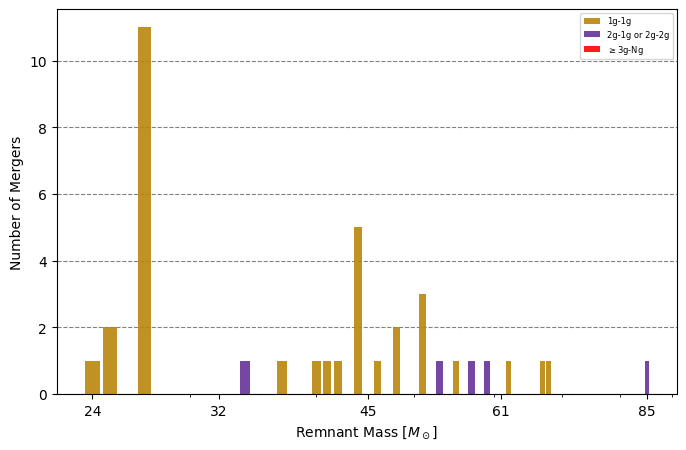

In [6]:
from mcfacts.vis import plotting, styles
import matplotlib.ticker as mticker
import numpy as np
figsize = "apj_col"

mergers = population_cabinet.get_array("blackholes_merged")
mass_final = mergers.mass_final

merger_g1_mask, merger_g2_mask, merger_gX_mask = make_gen_masks(mergers.gen_1, mergers.gen_2)

# Plot intial and final mass distributions
fig = plt.figure(figsize=(8, 5))
counts, bins = np.histogram(mass_final)
# plt.hist(bins[:-1], bins, weights=counts)
bins = np.arange(int(mass_final.min()), int(mass_final.max()) + 2, 1)

hist_data = [mass_final[merger_g1_mask], mass_final[merger_g2_mask], mass_final[merger_gX_mask]]
hist_label = ['1g-1g', '2g-1g or 2g-2g', r'$\geq$3g-Ng']
hist_color = [styles.color_gen1, styles.color_gen2, styles.color_genX]

plt.hist(hist_data, bins=bins, align='left', color=hist_color, alpha=0.9, rwidth=0.8, label=hist_label, stacked=True)

plt.ylabel('Number of Mergers')
plt.xlabel(r'Remnant Mass [$M_\odot$]')
plt.xscale('log')
# plt.ylim(-5,max(counts))
svf_ax = plt.gca()
svf_ax.set_axisbelow(True)
svf_ax.tick_params(axis='x', direction='out', which='both')
#plt.grid(True, color='gray', ls='dashed')
svf_ax.yaxis.grid(True, color='gray', ls='dashed')

plt.xticks(np.geomspace(int(mass_final.min()), int(mass_final.max()), 5).astype(int))
#plt.xticks(np.geomspace(20, 200, 5).astype(int))

svf_ax.xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:.0f}'))
svf_ax.xaxis.set_minor_formatter(mticker.NullFormatter())

if figsize == 'apj_col':
    plt.legend(fontsize=6)
elif figsize == 'apj_page':
    plt.legend()

#plt.savefig(opts.plots_directory + r"/merger_remnant_mass.png", format='png')
